In [1]:
# import packages
import torch
import yfinance as yf
import numpy as np
import paddle
import numpy as np
np.object = object
from paddle_quantum.gate import AmplitudeEncoding
import matplotlib.pyplot as plt
from qiskit_machine_learning.utils import algorithm_globals
from torch import nn
import pandas as pd
from scipy.stats import rankdata


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
I0117 12:27:43.944722 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0117 12:27:43.946163 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0117 12:27:43.946362 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0117 12:27:43.946463 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0117 12:27:43.946470 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0117 12:27:43.946749 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0117 12:27:43.946821 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0117 12:27:43.946842 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0117 12:27:43.946895 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0117 12:27:43.946916 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0117 12:27:43.946921 4266476096

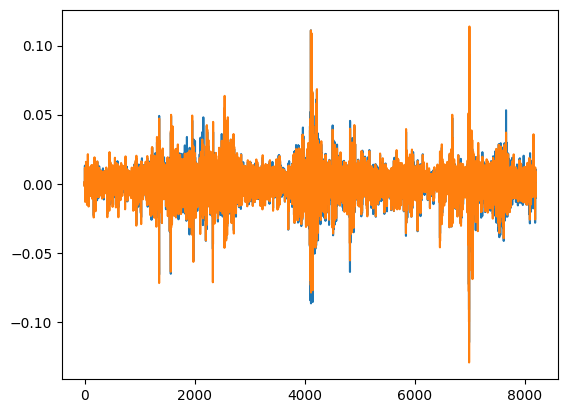

In [2]:
#load dataset

sp500 = yf.download('^GSPC', start='1992-06-19', end='2024-12-31')
dowjones = yf.download('^DJI', start='1992-06-19', end='2024-12-31')

# Compared to the Apple and Microsoft plot they have in the paper, this gives a similar result. To get it using amplitude encoding,
# we do need to preprocess the data as we were doing before, so putting it in a probability distribution.
sp500_returns = sp500['Close'].pct_change().dropna()
sp_returns = sp500_returns.values

dowjones_returns = dowjones['Close'].pct_change().dropna()
dj_returns = dowjones_returns.values


# encode in state amplitude
# We have 8192 datapoints, so we need 13 qubits to encode them
num_qubits = 13
qubits = 2*13

amplitude_enc = AmplitudeEncoding(num_qubits=num_qubits)
x,y = paddle.to_tensor(sp_returns), paddle.to_tensor(dj_returns)
state1,state2 = amplitude_enc(x), amplitude_enc(y)

data_im1,data_im2 = state1.numpy().tolist(), state2.numpy().tolist()
data1,data2 = np.real(data_im1), np.real(data_im2)
plt.plot(data1)
plt.plot(data2)
plt.show()

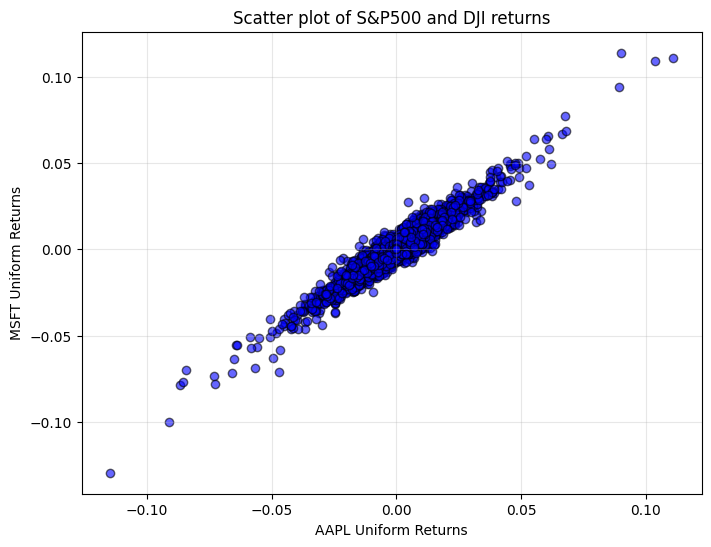

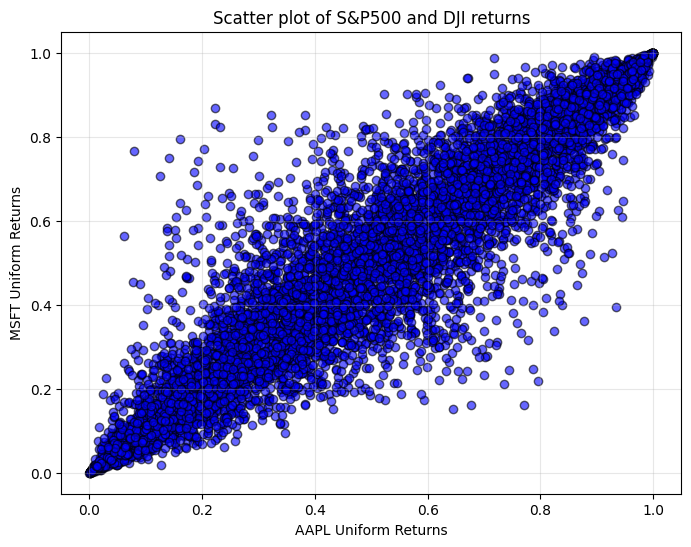

In [3]:
def empirical_cdf(data):
    ranks = rankdata(data, method='average')  # Rank the data
    uniform_data = ranks / (len(data) + 1)    # Normalize to [0, 1]
    return uniform_data

sp500_uniform = empirical_cdf(sp500_returns)
dj_uniform = empirical_cdf(dowjones_returns)

# Plot the scatter plot of returns
plt.figure(figsize=(8, 6))
plt.scatter(data1, data2, alpha=0.6, c='blue', edgecolor='k')
plt.title("Scatter plot of S&P500 and DJI returns")
plt.xlabel("AAPL Uniform Returns")
plt.ylabel("MSFT Uniform Returns")
plt.grid(alpha=0.3)
plt.show()


# Plot the scatter plot of uniform returns
plt.figure(figsize=(8, 6))
plt.scatter(sp500_uniform, dj_uniform, alpha=0.6, c='blue', edgecolor='k')
plt.title("Scatter plot of S&P500 and DJI returns")
plt.xlabel("AAPL Uniform Returns")
plt.ylabel("MSFT Uniform Returns")
plt.grid(alpha=0.3)
plt.show()

In [4]:
data_stack = np.column_stack((sp500_uniform,dj_uniform))
df2 = pd.DataFrame({
    'SP500': sp500_uniform,
    'DJI': dj_uniform
})

In [5]:
from copulas.bivariate import Clayton

copulas = Clayton()
copulas.fit(data_stack)

samples = copulas.sample(1000)
samples = pd.DataFrame(samples, columns=['SP500', 'DJI'])

In [6]:
from copulas.visualization import compare_2d
compare_2d(df2, samples)

Circuit with Bell pairs:


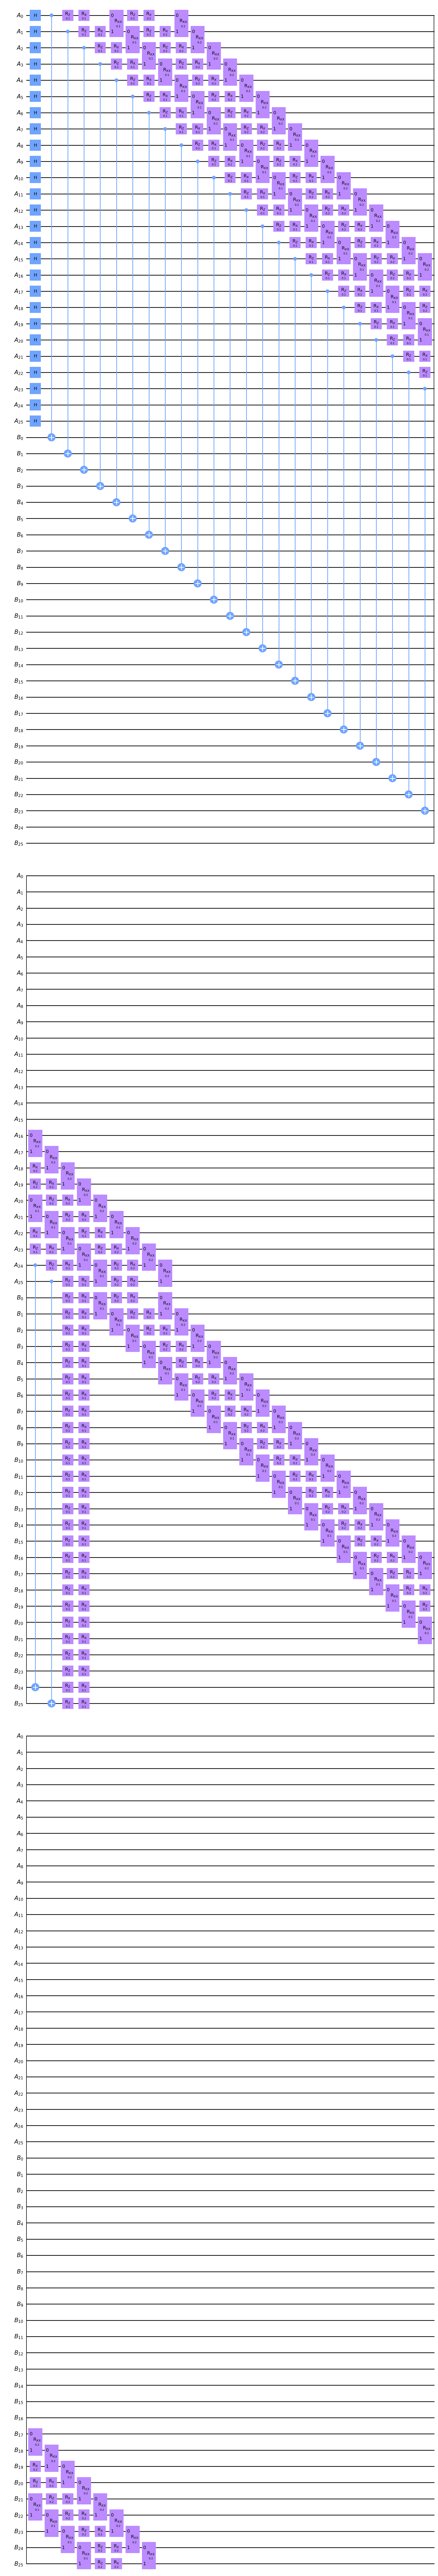

In [22]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RXXGate

def create_bell_pair_circuit(num_qubits=13):
    # Create two quantum registers A and B with num_qubits each
    qr_a = QuantumRegister(num_qubits, 'A')
    qr_b = QuantumRegister(num_qubits, 'B')
    qc = QuantumCircuit(qr_a, qr_b)

    # Step 1: Apply H gates to all qubits in register A
    qc.h(qr_a)

    # Step 2: Apply CNOT gates between corresponding qubits in A and B
    for i in range(num_qubits):
        qc.cx(qr_a[i], qr_b[i])

    return qc

def create_ghz_state_circuit(num_qubits=13):
    # Create two quantum registers A and B with num_qubits each
    qr_a = QuantumRegister(num_qubits, 'A')
    qr_b = QuantumRegister(num_qubits, 'B')
    qc = QuantumCircuit(qr_a, qr_b)

    # Step 1: Create GHZ state for register A
    qc.h(qr_a[0])  # Apply Hadamard to the first qubit
    for i in range(1, num_qubits):
        qc.cx(qr_a[i-1], qr_a[i])  # Chain CNOT gates to form GHZ state

    # Step 2: Create GHZ state for register B
    qc.h(qr_b[0])  # Apply Hadamard to the first qubit
    for i in range(1, num_qubits):
        qc.cx(qr_b[i-1], qr_b[i])  # Chain CNOT gates to form GHZ state

    return qc

def add_unitary_layers(qc, qr, num_layers=2):
    # Add alternating "driver" and "entangler" layers to a register
    num_qubits = len(qr)
    for layer in range(num_layers):
        # Driver layer: Apply RZ and RX rotations
        for i in range(num_qubits):
            qc.rz(0.1 * (layer + 1), qr[i])  # Example parameterization
            qc.rx(0.1 * (layer + 1), qr[i])  # Example parameterization

        # Entangler layer: Apply RXX gates between neighboring qubits
        for i in range(num_qubits - 1):
            qc.append(RXXGate(0.1 * (layer + 1)), [qr[i], qr[i+1]])  # Example parameterization

    return qc

def create_qopula_circuit(num_qubits=qubits, num_layers=2, ghz=False):
    if ghz:
        qc = create_ghz_state_circuit(num_qubits)
    else:
        qc = create_bell_pair_circuit(num_qubits)

    # Add unitary layers to both registers
    qc = add_unitary_layers(qc, qc.qregs[0], num_layers)  # Register A
    qc = add_unitary_layers(qc, qc.qregs[1], num_layers)  # Register B

    return qc

# Example: Create the Qopula circuit with 13 qubits per register
# First, using Bell pairs:
bell_qopula_circuit = create_qopula_circuit(num_qubits=qubits, num_layers=2, ghz=False)
print("Circuit with Bell pairs:")
bell_qopula_circuit.draw(output='mpl',style='clifford')



Circuit with GHZ states:


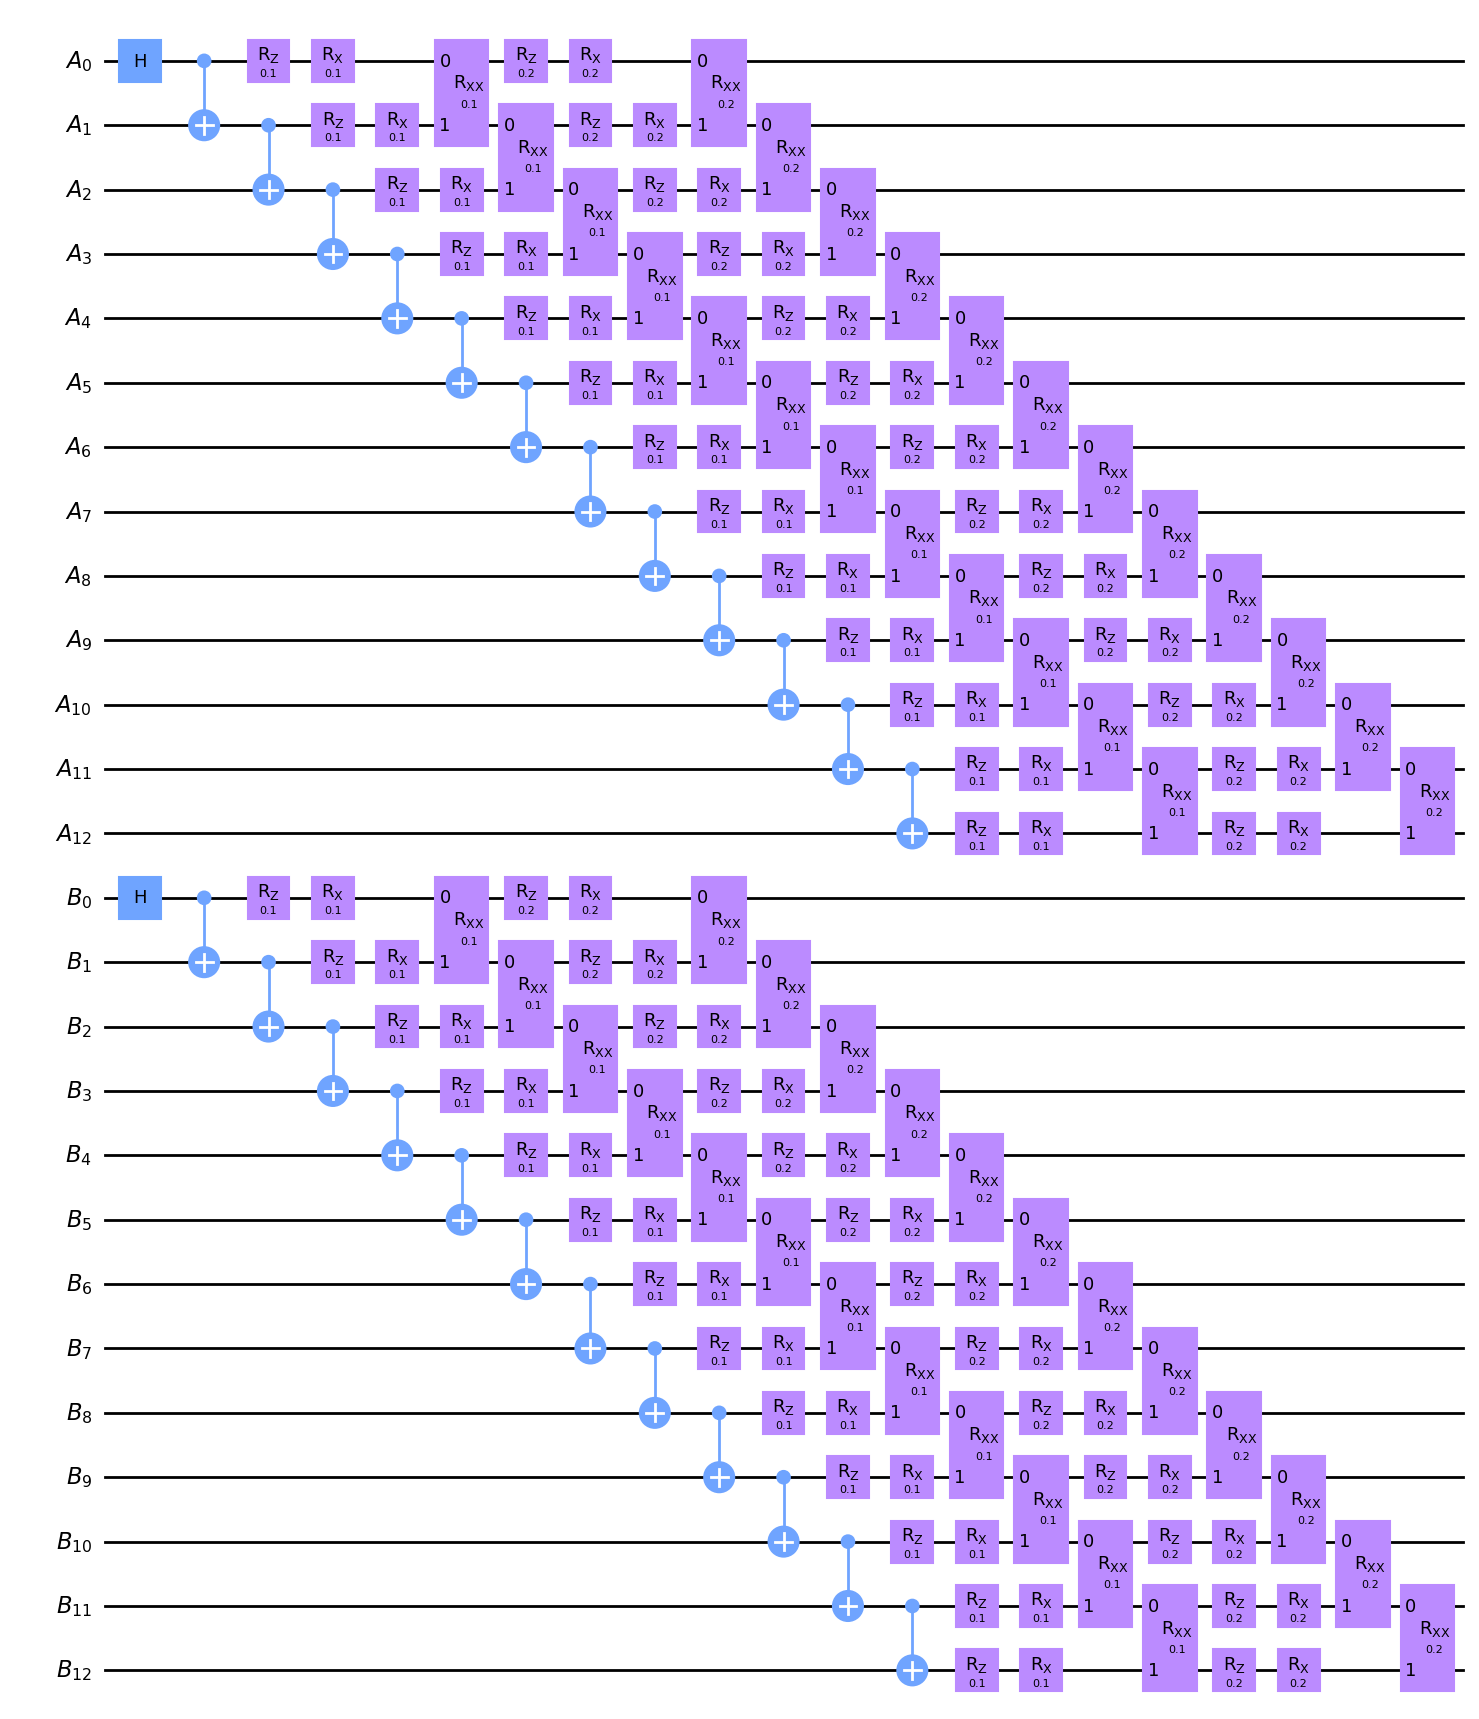

In [ ]:
# Then, using GHZ states:
ghz_qopula_circuit = create_qopula_circuit(num_qubits=13, num_layers=2, ghz=True)
print("\nCircuit with GHZ states:")
#ghz_qopula_circuit.draw(output='mpl',style='clifford')

In [23]:
# define generator
from qiskit_aer import AerSimulator
class QuantumGenerator:
    def __init__(self, num_qubits, layers=1):
        self.num_qubits = num_qubits
        self.layers = layers
        self.params = np.random.uniform(0, 2 * np.pi, size=(layers, 2 * num_qubits))
        self.backend = AerSimulator()


# define discriminator 
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 32)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

In [24]:
generator = QuantumGenerator(num_qubits)
discriminator = Discriminator(2)

In [25]:
# define loss functions
# BCE loss function
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

# WGAN loss function
def wgan_loss(pred, target_is_real):
    return -torch.mean(pred) if target_is_real else torch.mean(pred)

In [11]:
# add optimizers 

# SPSA optimizer


# Adam optimizer
from torch.optim import Adam

lr = 0.0001  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter
discriminator_optimizer = Adam(discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)

In [12]:
# define plot function

In [13]:
# define training function